<a href="https://colab.research.google.com/github/emichester/06MIAR_Aprendizaje_No_Supervisado/blob/main/TrabajoFinal/DCGAN_FashionMNIST_Pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este ejemplo vamos a tratar de generar imágenes similares a las del dataset de ropa FashionMNIST.

Pero esta vez lo váis a hacer vosotros :)

In [1]:
# importamos las librerías necesarias
import numpy as np
# buscad el dataset Fashion MNIST disponible en Keras e importadlo
from tensorflow.keras.datasets.fashion_mnist import load_data
# https://keras.io/datasets/
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, MaxPooling2D, UpSampling2D, BatchNormalization
import matplotlib.pyplot as plt

In [12]:
# # definimos el generador
# def define_generator(latent_dim):

#     model = Sequential(name="GENERATOR")

#     n_nodes = 128 * 7 * 7

#     # Bloque 1
#     model.add(Dense(n_nodes, input_dim=latent_dim))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Reshape((7, 7, 128)))

#     # aumentamos a 14x14
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     # aumentamos a 28x28 (el tamaño deseado final, ya que es el mismo que el de
#     # las imágenes del MNIST)
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

#     model.summary()

#     return model

# definimos el generador
def define_generator(latent_dim):

    model = Sequential(name="GENERATOR")

    n_nodes = 128 * 7 * 7

    # Bloque 1
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # Bloque 2
    # aumentamos a 14x14
    model.add(Conv2DTranspose(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D((2,2)))

    # Bloque 3
    # aumentamos a 28x28 (el tamaño deseado final, ya que es el mismo que el de
    # las imágenes del FashionMNIST)
    model.add(Conv2DTranspose(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D((2,2)))

    # Top model
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    model.summary()

    return model

In [13]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28,28,1)):

    model = Sequential(name="DISCRIMINATOR")

    # Bloque 1
    model.add(Conv2D(128, (3,3), input_shape=in_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Top model
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compilamos el modelo
    opt = Adam(lr=1e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()

    return model

In [14]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # Así que congelamos el discriminador:
    d_model.trainable = False
    # ahora conectamos el G(z) al D(x)
    model = Sequential()
    # añadimos el generador primero: él es el encargado de generar una muestra
    # a partir del espacio latente
    model.add(g_model)
    # y el discriminador después: le introducimos la muestra generada por el
    # G(z) para que nos diga si cree que es real o fake
    model.add(d_model)
    # y ahora sí, compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return model

In [15]:
# definimos las funciones para cargar el MNIST
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# nos creamos una función que nos devuelva n_samples del dataset con sus
# etiquetas (1)
def generate_real_samples(dataset, n_samples):
    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # las cogemos
    X = dataset[ix]
    # generamos las etiquetas reales (1)
    y = np.ones((n_samples, 1))
    return X, y

In [16]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = np.random.randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples):
    # usamos la función anterior para generar los vectores latentes que
    # necesitamos para generar muestras fake
    x_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes al generador para obtener
    # muestras similares a las reales
    X = g_model.predict(x_input)
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)
    y = np.zeros((n_samples, 1))
    return X, y

In [17]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [23]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # bucle para las epochs
    for epoch in range(n_epochs):
        # bucle para los batch
        for batch in range(bat_per_epo):
            # preparamos los datos reales
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generamos 'half_batch' datos falsos
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # juntamos las imágenes/etiquetas reales con las falsas
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # actualizamos los pesos del discriminador
            d_loss, _ = d_model.train_on_batch(X, y)
            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador
            X_gan = generate_latent_points(latent_dim, n_batch)
            # creamos etiquetas invertidas para el generador: utilizamos el D(x)
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los
            # reales)
            y_gan = np.ones((n_batch, 1))
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # mostramos el progreso
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))

        # evaluamos el desempeño del modelo cada 10 épocas
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos ejemplos reales
            X_real, y_real = generate_real_samples(dataset, n_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
            # preparamos ejemplos fake
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(x_fake, epoch)
            # guardamos el generador para tenerlo disponible más tarde
            filename = 'generator_model_%03d.h5' % (epoch + 1)
            g_model.save(filename)

In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

Model: "DISCRIMINATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_9 (Bat  (None, 28, 28, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)     

In [25]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30)

2/2 [==============================] - 0s 9ms/step
>1, 1/468, d=1.963, g=0.742
2/2 [==============================] - 0s 6ms/step
>1, 2/468, d=0.149, g=0.755
2/2 [==============================] - 0s 5ms/step
>1, 3/468, d=0.157, g=0.709
2/2 [==============================] - 0s 5ms/step
>1, 4/468, d=0.577, g=0.509
2/2 [==============================] - 0s 6ms/step
>1, 5/468, d=0.235, g=0.340
2/2 [==============================] - 0s 5ms/step
>1, 6/468, d=0.011, g=0.222
2/2 [==============================] - 0s 7ms/step
>1, 7/468, d=0.005, g=0.154
2/2 [==============================] - 0s 6ms/step
>1, 8/468, d=0.003, g=0.101
2/2 [==============================] - 0s 6ms/step
>1, 9/468, d=0.002, g=0.057
2/2 [==============================] - 0s 6ms/step
>1, 10/468, d=0.002, g=0.034
2/2 [==============================] - 0s 8ms/step
>1, 11/468, d=0.002, g=0.016
2/2 [==============================] - 0s 9ms/step
>1, 12/468, d=0.013, g=0.007
2/2 [==============================] - 0s 5ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 6ms/step
>5, 310/468, d=0.378, g=5.903
2/2 [==============================] - 0s 7ms/step
>5, 311/468, d=0.356, g=2.317
2/2 [==============================] - 0s 4ms/step
>5, 312/468, d=0.369, g=4.891
2/2 [==============================] - 0s 8ms/step
>5, 313/468, d=0.425, g=2.099
2/2 [==============================] - 0s 5ms/step
>5, 314/468, d=0.399, g=2.661
2/2 [==============================] - 0s 7ms/step
>5, 315/468, d=0.358, g=1.088
2/2 [==============================] - 0s 5ms/step
>5, 316/468, d=0.344, g=2.741
2/2 [==============================] - 0s 6ms/step
>5, 317/468, d=0.300, g=5.152
2/2 [==============================] - 0s 10ms/step
>5, 318/468, d=0.345, g=4.565
2/2 [==============================] - 0s 5ms/step
>5, 319/468, d=0.443, g=5.037
2/2 [==============================] - 0s 8ms/step
>5, 320/468, d=0.457, g=0.798
2/2 [==============================] - 0s 13ms/

Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 12ms/step
>15, 310/468, d=0.287, g=1.577
2/2 [==============================] - 0s 5ms/step
>15, 311/468, d=0.291, g=0.972
2/2 [==============================] - 0s 14ms/step
>15, 312/468, d=0.350, g=2.768
2/2 [==============================] - 0s 4ms/step
>15, 313/468, d=0.207, g=4.198
2/2 [==============================] - 0s 8ms/step
>15, 314/468, d=0.198, g=4.390
2/2 [==============================] - 0s 5ms/step
>15, 315/468, d=0.320, g=3.407
2/2 [==============================] - 0s 5ms/step
>15, 316/468, d=0.364, g=6.819
2/2 [==============================] - 0s 6ms/step
>15, 317/468, d=0.322, g=6.020
2/2 [==============================] - 0s 7ms/step
>15, 318/468, d=0.366, g=1.498
2/2 [==============================] - 0s 5ms/step
>15, 319/468, d=0.232, g=1.988
2/2 [==============================] - 0s 14ms/step
>15, 320/468, d=0.189, g=4.575
2/2 [=============================

Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 17ms/step
>25, 310/468, d=0.325, g=6.248
2/2 [==============================] - 0s 7ms/step
>25, 311/468, d=0.262, g=3.343
2/2 [==============================] - 0s 7ms/step
>25, 312/468, d=0.232, g=3.137
2/2 [==============================] - 0s 14ms/step
>25, 313/468, d=0.263, g=5.148
2/2 [==============================] - 0s 7ms/step
>25, 314/468, d=0.221, g=4.222
2/2 [==============================] - 0s 7ms/step
>25, 315/468, d=0.310, g=1.244
2/2 [==============================] - 0s 12ms/step
>25, 316/468, d=0.241, g=1.883
2/2 [==============================] - 0s 8ms/step
>25, 317/468, d=0.294, g=3.600
2/2 [==============================] - 0s 5ms/step
>25, 318/468, d=0.247, g=6.012
2/2 [==============================] - 0s 8ms/step
>25, 319/468, d=0.315, g=2.957
2/2 [==============================] - 0s 7ms/step
>25, 320/468, d=0.196, g=1.183
2/2 [=============================

In [26]:
%ls

generated_plot_e001.png  generated_plot_e030.png  generator_model_020.h5
generated_plot_e010.png  generator_model_001.h5   generator_model_030.h5
generated_plot_e020.png  generator_model_010.h5   sample_data/


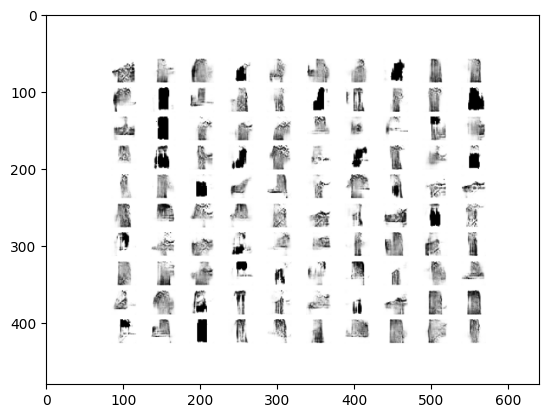

In [27]:
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

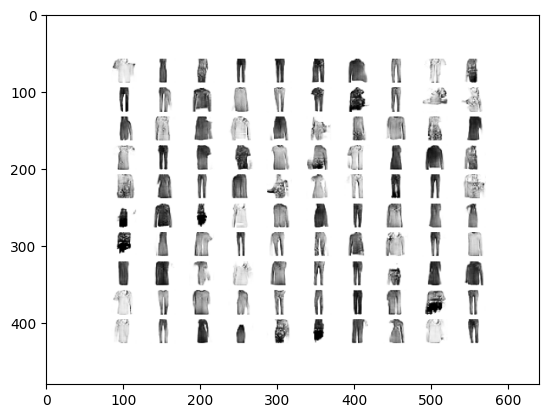

In [28]:
plt.imshow(plt.imread('generated_plot_e010.png'))
plt.show()

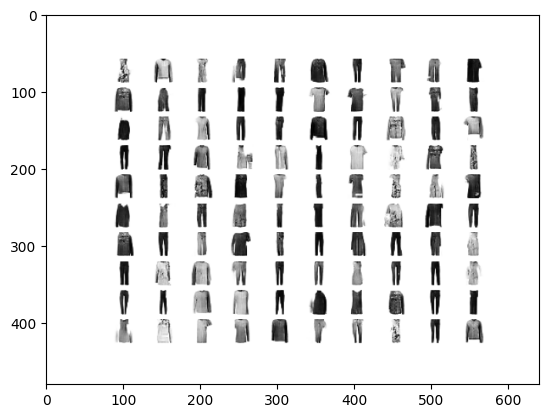

In [29]:
plt.imshow(plt.imread('generated_plot_e030.png'))
plt.show()

In [ ]:
plt.imshow(plt.imread('generated_plot_e100.png'))
plt.show()

Nada mal, ¿verdad? Pero... ¿y si quisiéramos generar solo zapatos? ¿O solo camisetas?

Para ello, necesitamos transformar esta GAN en una GAN condicional o CGAN.

Podéis guiaros con este ejemplo: https://keras.io/examples/generative/conditional_gan/.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import os
import glob
import shutil # https://stackoverflow.com/questions/123198/how-to-copy-files

In [48]:
for src in glob.glob("/content/*.*"):
    dst = os.path.join(
        "/content/drive/MyDrive/ASIGNATURAS/VIU/06MIAR_Aprendizaje_no_Supervisado/TrabajoFinal/",
        os.path.basename(src))
    shutil.copyfile(src, dst)

In [49]:
%ls /content/drive/MyDrive/ASIGNATURAS/VIU/06MIAR_Aprendizaje_no_Supervisado/TrabajoFinal/

generated_plot_e001.png  generated_plot_e020.png  generator_model_001.h5  generator_model_020.h5
generated_plot_e010.png  generated_plot_e030.png  generator_model_010.h5  generator_model_030.h5


In [51]:
def plot_results(imgs, n_rows, n_cols, epoch, h=192, w=192):
    imgs = (imgs + 1) / 2.0
    output_img = np.zeros((n_rows*h, n_cols*w, 3), np.float)
    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            output_img[h*i:h*(i+1), w*j:w*(j+1), :] = imgs[k]
            k += 1
    plt.imshow(np.asarray(output_img*255., np.uint8))

In [75]:
n_samples = 64

2/2 [==============================] - 0s 8ms/step


<ipython-input-51-cbfdd34118e8>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_img = np.zeros((n_rows*h, n_cols*w, 3), np.float)


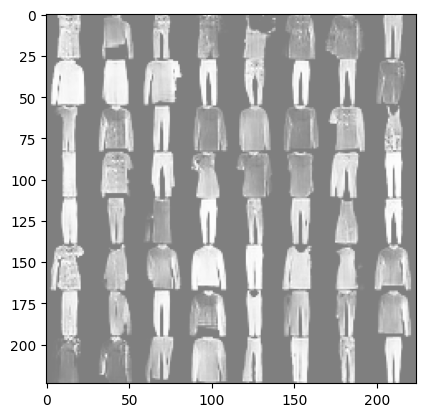

In [76]:
# generamos imágenes diferentes con un código latente distinto
x_input = generate_latent_points(latent_dim, n_samples)

# g_model = define_generator(latent_dim)
# _last_checkpoint = sorted(os.listdir("./checkpoints/"))[-1]
# g_model.load_weights(os.path.join("./checkpoints/",_last_checkpoint))
X = g_model.predict(x_input)
plot_results(X, 8, 8, 200, h=28, w=28)

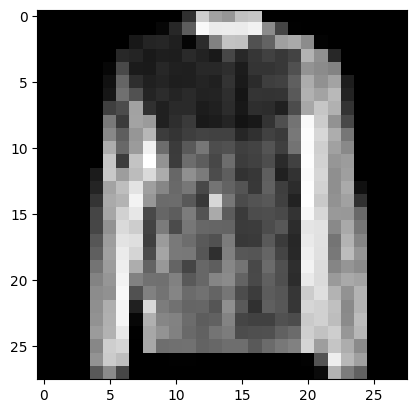

In [78]:
plt.imshow(X[17,:,:,:], cmap="gray")